In [2]:
from research_common.spark import create_yarn_spark_session
from pyspark.sql import functions as F
conf =  {
    "spark.dynamicAllocation.maxExecutors": 100,
    "spark.executor.cores": 4,
    # "spark.sql.shuffle.partitions": 2000,
    "spark.executor.memory": "14g",
    "spark.executor.memoryOverhead": "2g",
}
spark = create_yarn_spark_session(app_id='knowledge_gaping',extra_config=conf,gitlab_project='repos/research/knowledge-gaps')

SPARK_HOME: /usr/lib/spark3/
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_DRIVER_PYTHON=python
PYSPARK_PYTHON=./env/bin/python
:: loading settings :: url = jar:file:/opt/conda-analytics/lib/python3.10/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/fab/.ivy2/cache
The jars for the packages stored in: /home/fab/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e90030dd-1644-4c86-b835-4262e0e969e8;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.1.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
:: resolution report :: resolve 187ms :: artifacts dl 4ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.1.2 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------------

In [2]:

metrics_df = (spark
    .sql("SELECT * FROM fab.by_category")
).cache()

metrics_df.show()

content_gaps = [ r.content_gap for r in metrics_df.select('content_gap').distinct().collect()]
content_gaps

23/08/16 15:39:33 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


+------------+-------------------+--------------------+--------------------+------------------+-----------+
|     wiki_db|           category|             metrics|           quantiles|       content_gap|time_bucket|
+------------+-------------------+--------------------+--------------------+------------------+-----------+
|     adywiki|                 ME|{null, 58, 58.0, ...|{null, [58, 58, 5...| geography_country|    2022-03|
| commonswiki|           intersex|{null, null, null...|{null, null, null...|            gender|    2022-03|
|     vlswiki|                 UY|{null, 304, 304.0...|{null, [304, 304,...| geography_country|    2022-03|
|     ndswiki|         non-binary|{null, 14, 14.0, ...|{null, [14, 14, 1...|            gender|    2022-03|
|fiwikivoyage|                 TR|{null, null, null...|{null, null, null...| geography_country|    2022-03|
|      cywiki|     cisgender male|{null, 15, 15.0, ...|{null, [15, 15, 1...|            gender|    2022-03|
|      kgwiki|              

['gender',
 'time',
 'geography_wmf_region',
 'geography_cultural_region',
 'multimedia_illustrated',
 'sexual_orientation',
 'geography_continent',
 'geography_country']

In [3]:
metrics_normalized_df = (spark
    .sql("SELECT * FROM fab.normalized")
).cache()


In [3]:
metrics_normalized_df

DataFrame[wiki_db: string, by_category: map<string,map<string,map<string,double>>>, by_content_gap: map<string,map<string,double>>, content_gap: string]

In [1]:
# %matplotlib notebook
%matplotlib widget
from datetime import datetime
from knowledge_gaps.util import get_time_buckets
import matplotlib.pyplot as plt
from matplotlib import dates
from IPython.display import display, Markdown

start_date = datetime.strptime('20120101', '%Y%m%d')
end_date = datetime.strptime('20230701', '%Y%m%d')
time_bucket_freq = 'monthly'
time_buckets = get_time_buckets(
    start_date, end_date, time_bucket_freq
)

# make dense representation of timeseries for plotting
def make_dense(time_buckets, sparse):
    """returns a dense timeseries array """
    return [ sparse.get(tb,0.0) for tb in time_buckets ]


x_dates = [datetime.strptime(tb,'%Y-%m').date() for tb in time_buckets]

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [32, 8]

def content_gap_summary(gap_df, projects=['enwiki'], metrics_to_plot=['article_created', 'pageviews_sum', 'pageviews_mean', 'revision_count','quality_score'],topN=5):

    data = (gap_df.collect())    
    for project in projects:
        display(Markdown(f'### {project}'))
        fig, axs = plt.subplots(1,len(metrics_to_plot))
        fig.suptitle(f'Project {project}')        
        for i,row in enumerate([r for r in data if r.wiki_db==project]):                        
            for j, metric in enumerate(metrics_to_plot):
                top_categories = sorted(row.by_category.items(),key=lambda kv: sum(kv[1][metric].values()),reverse=True)[:topN]
                for cat,metrics in top_categories:
                    axs[j].set_title(metric)
                    axs[j].xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))
                    axs[j].xaxis.set_major_locator(dates.MonthLocator(interval=10))
                    axs[j].plot(x_dates, make_dense(time_buckets, metrics[metric]), label=f'{cat}')                    
                
        fig.autofmt_xdate()
        for ax in axs:
            ax.legend()
        # fig.show()
            
        
# content_gap_summary(gender,projects=['enwiki', 'swwiki', 'arwiki', 'bnwiki', 'cawiki'],topN=2,topN_metric='article_created')

def summary_per_gap(metrics_df, 
                    gaps=['gender', 'sexual_orientation', 'geography_wmf_region'],
                    projects=['enwiki']):                    
    for gap in gaps:
        display(Markdown(f'## *{gap}*'))
        df = metrics_df.where(F.col('content_gap')==gap).where(F.col('wiki_db').isin(projects))    
        content_gap_summary(df,projects,topN=5)

In [6]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: comm
    Found existing installation: comm 0.1.0
    Uninstalling comm-0.1.0:
      Successfully uninstalled comm-0.1.0


In [ ]:
summary_per_gap(metrics_normalized_df,gaps=['gender', 'sexual_orientation', 'geography_wmf_region'],projects=['enwiki', 'swwiki', 'arwiki', 'bnwiki', 'cawiki'])        

## *gender*

23/08/16 18:24:12 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


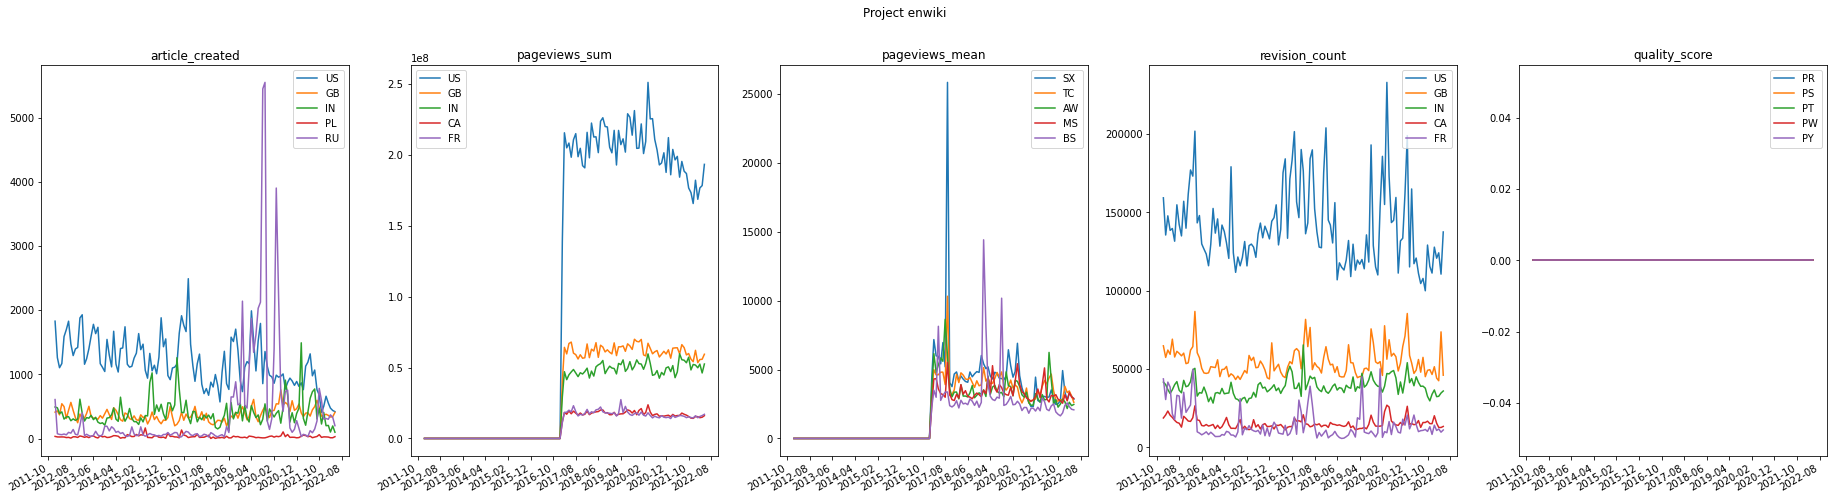

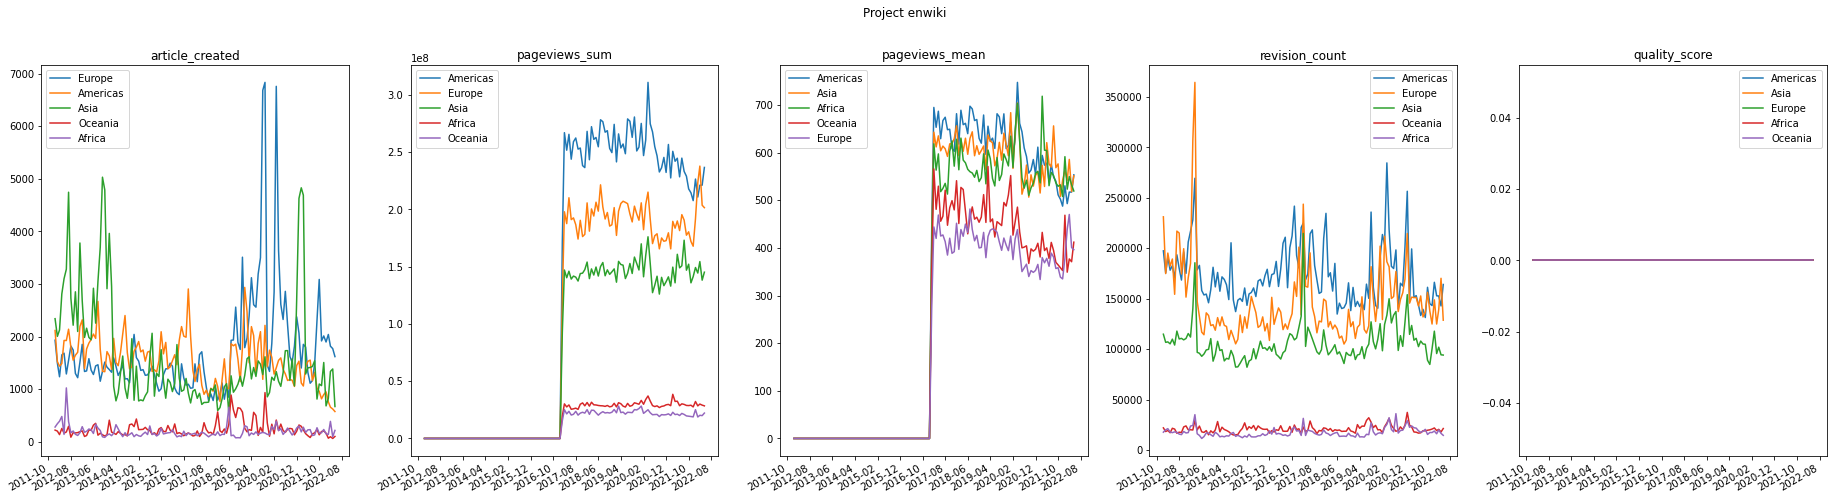

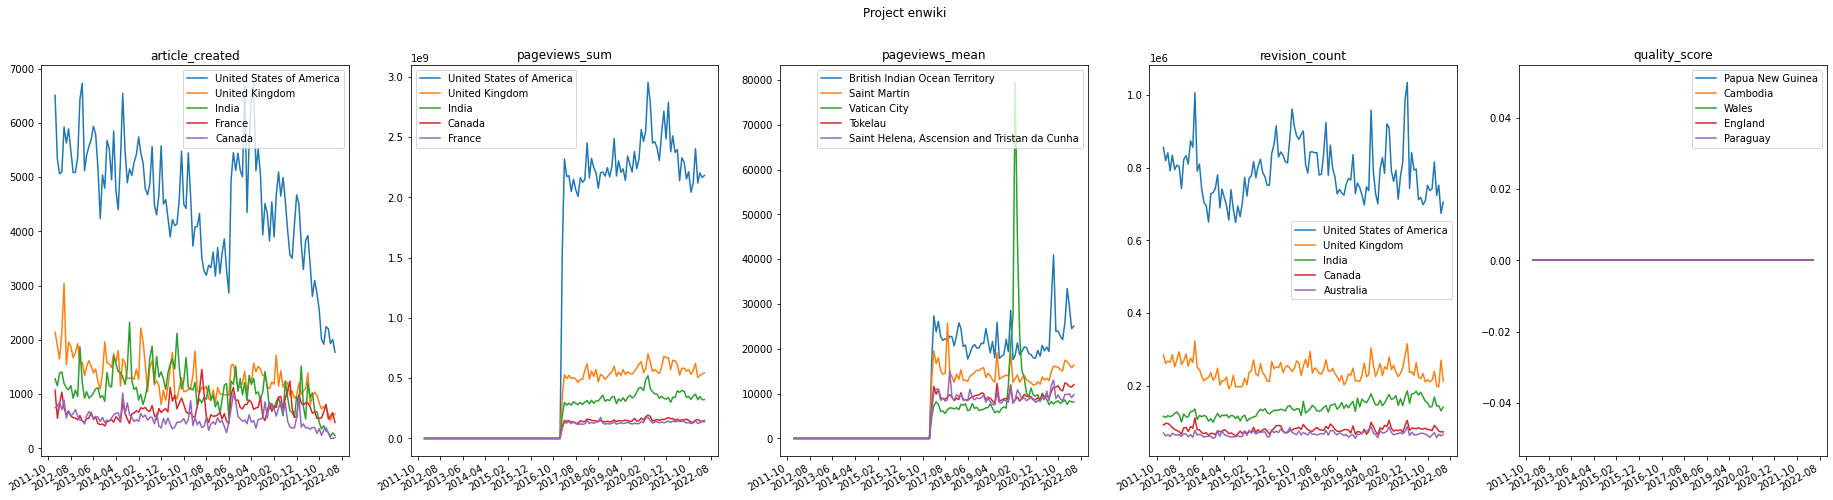

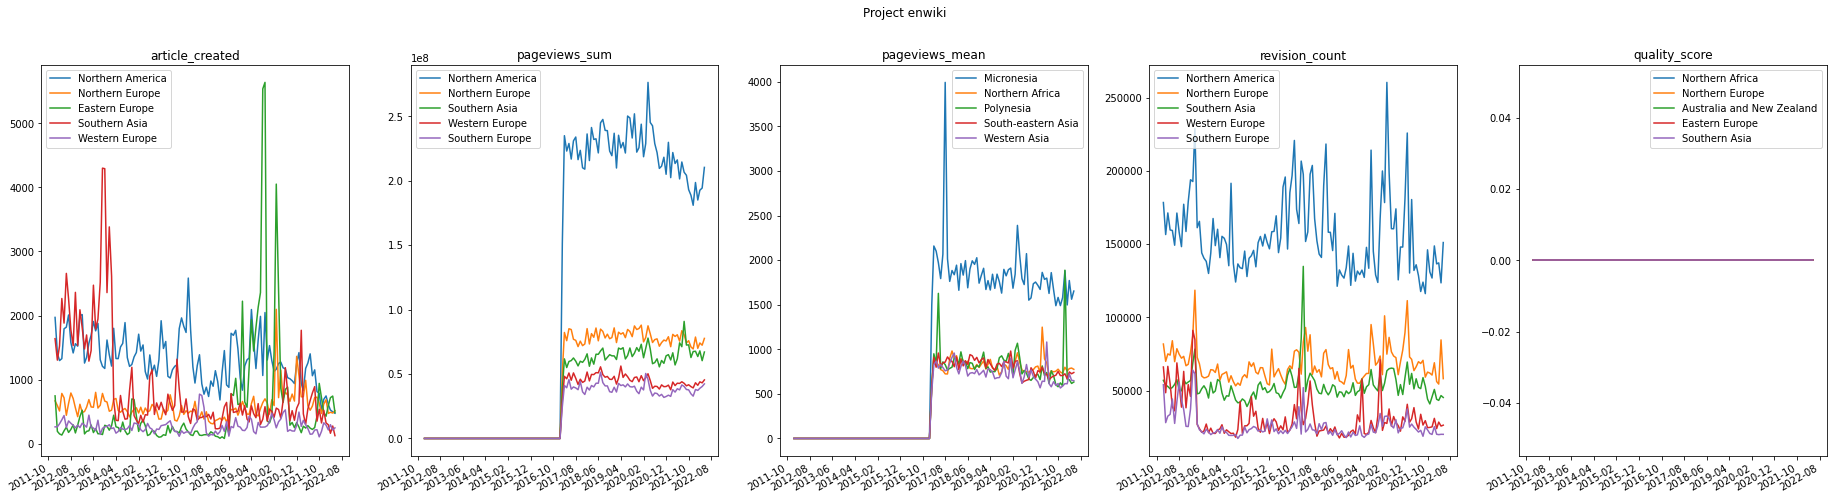

In [6]:
geo_gaps = [ 'geographic','geographic_continent', 'geographic_region', 'geographic_sub_continent']
summary_per_gap(metrics_normalized_df,gaps=geo_gaps,projects=['enwiki'])
# content_gaps

In [21]:
def categorize_year(years):
    import numpy as np
    years = [y for y in years if y is not None]
    if years:
        year = int(np.median(years))
        if year < -10000:
            return '10+ millenia BC'
        if year < 0:
            return f'{(-1*year) // 1000 + 1 }th millenia BC'
        elif year < 1900:
            return f'{(year) // 100 + 1 }th century'
        elif year < 1990:
            return f'{(year) // 10 }0s'
        elif year < 2030:
            return f'year {year}'
        else:
            return 'year 2030+'
    else:
        return 'Unknown'

    

cats = []
seen = set()
for y in range(-10001,2031):
    c = categorize_year([y])
    if c not in seen:
        cats.append(c)
        seen.add(c)
        
cats

['10+ millenia BC',
 '11th millenia BC',
 '10th millenia BC',
 '9th millenia BC',
 '8th millenia BC',
 '7th millenia BC',
 '6th millenia BC',
 '5th millenia BC',
 '4th millenia BC',
 '3th millenia BC',
 '2th millenia BC',
 '1th millenia BC',
 '1th century',
 '2th century',
 '3th century',
 '4th century',
 '5th century',
 '6th century',
 '7th century',
 '8th century',
 '9th century',
 '10th century',
 '11th century',
 '12th century',
 '13th century',
 '14th century',
 '15th century',
 '16th century',
 '17th century',
 '18th century',
 '19th century',
 '1900s',
 '1910s',
 '1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 'year 1990',
 'year 1991',
 'year 1992',
 'year 1993',
 'year 1994',
 'year 1995',
 'year 1996',
 'year 1997',
 'year 1998',
 'year 1999',
 'year 2000',
 'year 2001',
 'year 2002',
 'year 2003',
 'year 2004',
 'year 2005',
 'year 2006',
 'year 2007',
 'year 2008',
 'year 2009',
 'year 2010',
 'year 2011',
 'year 2012',
 'year 2013',
 'year 2014',
 'ye

In [33]:
time[0].totals['quality_score']

{'2022-05': 0.43212515592945855}

In [61]:
def categorize_year(years):
    import numpy as np
    years = [y for y in years if y is not None]
    if years:
        year = int(np.median(years))
        if year < -10000:
            return '10+ millenia BC'
        if year < 0:
            return f'{(-1*year) // 1000 + 1 }th millenia BC'
        elif year < 1900:
            return f'{(year) // 100 + 1 }th century'
        elif year < 1990:
            return f'{(year) // 10 }0s'
        elif year < 2030:
            return f'year {year}'
        else:
            return 'year 2030+'
    else:
        return 'Unknown'

    

time_categories = []
seen = set()
for y in range(-10001,2031):
    c = categorize_year([y])
    if c not in seen:
        time_categories.append(c)
        seen.add(c)

# article quality only available for latest revision
article_quality_snapshot='2022-05'
        
metrics_ts_agg = {
    'article_created': lambda ts: sum(ts.values()),
    'pageviews_sum': lambda ts: sum(ts.values()),
    'pageviews_mean': lambda ts: sum(ts.values())/len(ts),
    'revision_count': lambda ts: sum(ts.values()),
    'quality_score': lambda ts: ts[article_quality_snapshot],
}        
plt.rcParams['figure.figsize'] = [20, 24]

def time_gap(gap_df, projects=['enwiki'], metrics_to_plot=['article_created', 'pageviews_sum', 'pageviews_mean','revision_count','quality_score']):

    data = gap_df.where(F.col('content_gap')=='time').where(F.col('wiki_db').isin(projects)).collect()

    for project in projects:
        fig, axs = plt.subplots(len(metrics_to_plot),1)
        fig.suptitle(f'Project {project}')                
        for i,row in enumerate([r for r in data if r.wiki_db==project]):                    
            for j, metric in enumerate(metrics_to_plot):
                axs[j].set_title(metric)
                
                for tc in time_categories:
                    if tc in row.categories:
                        val = metrics_ts_agg[metric](row.categories[tc][metric])
                    else:
                        val = 0
                    axs[j].bar(tc,val)

        for ax in axs[:-1]:
            ax.tick_params(labelbottom=False)
        axs[-1].tick_params(labelrotation=90)




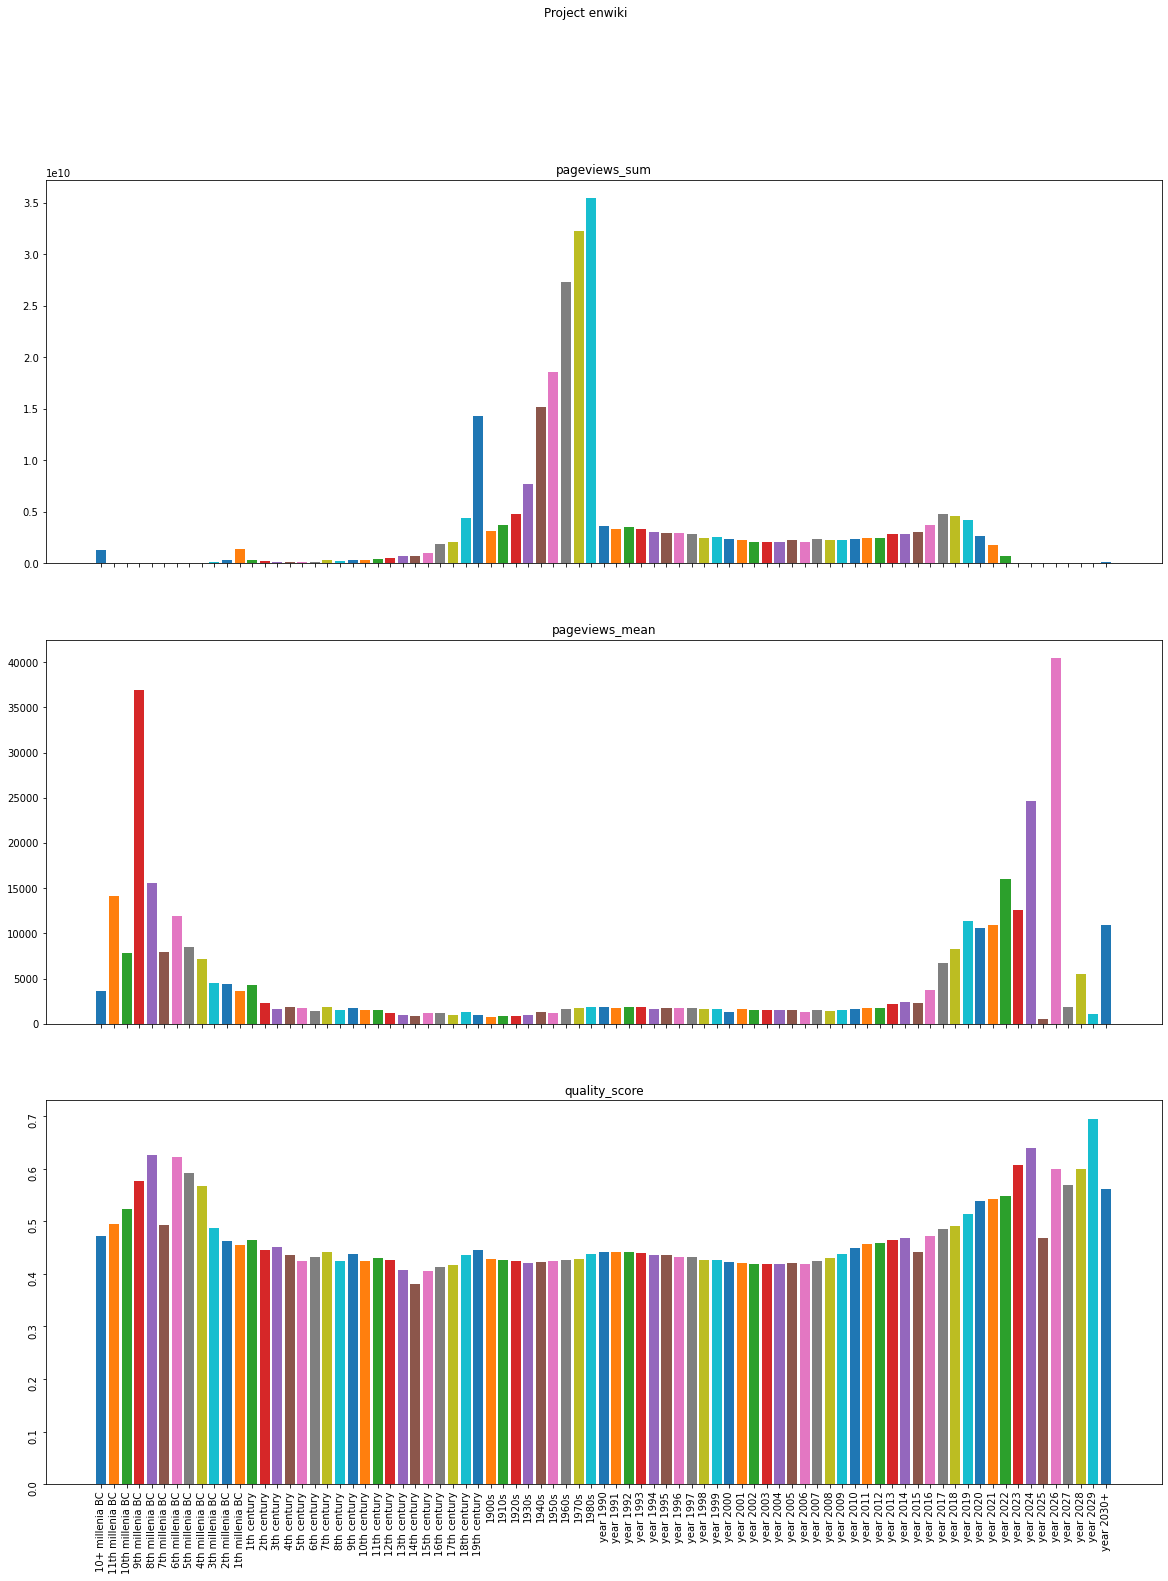

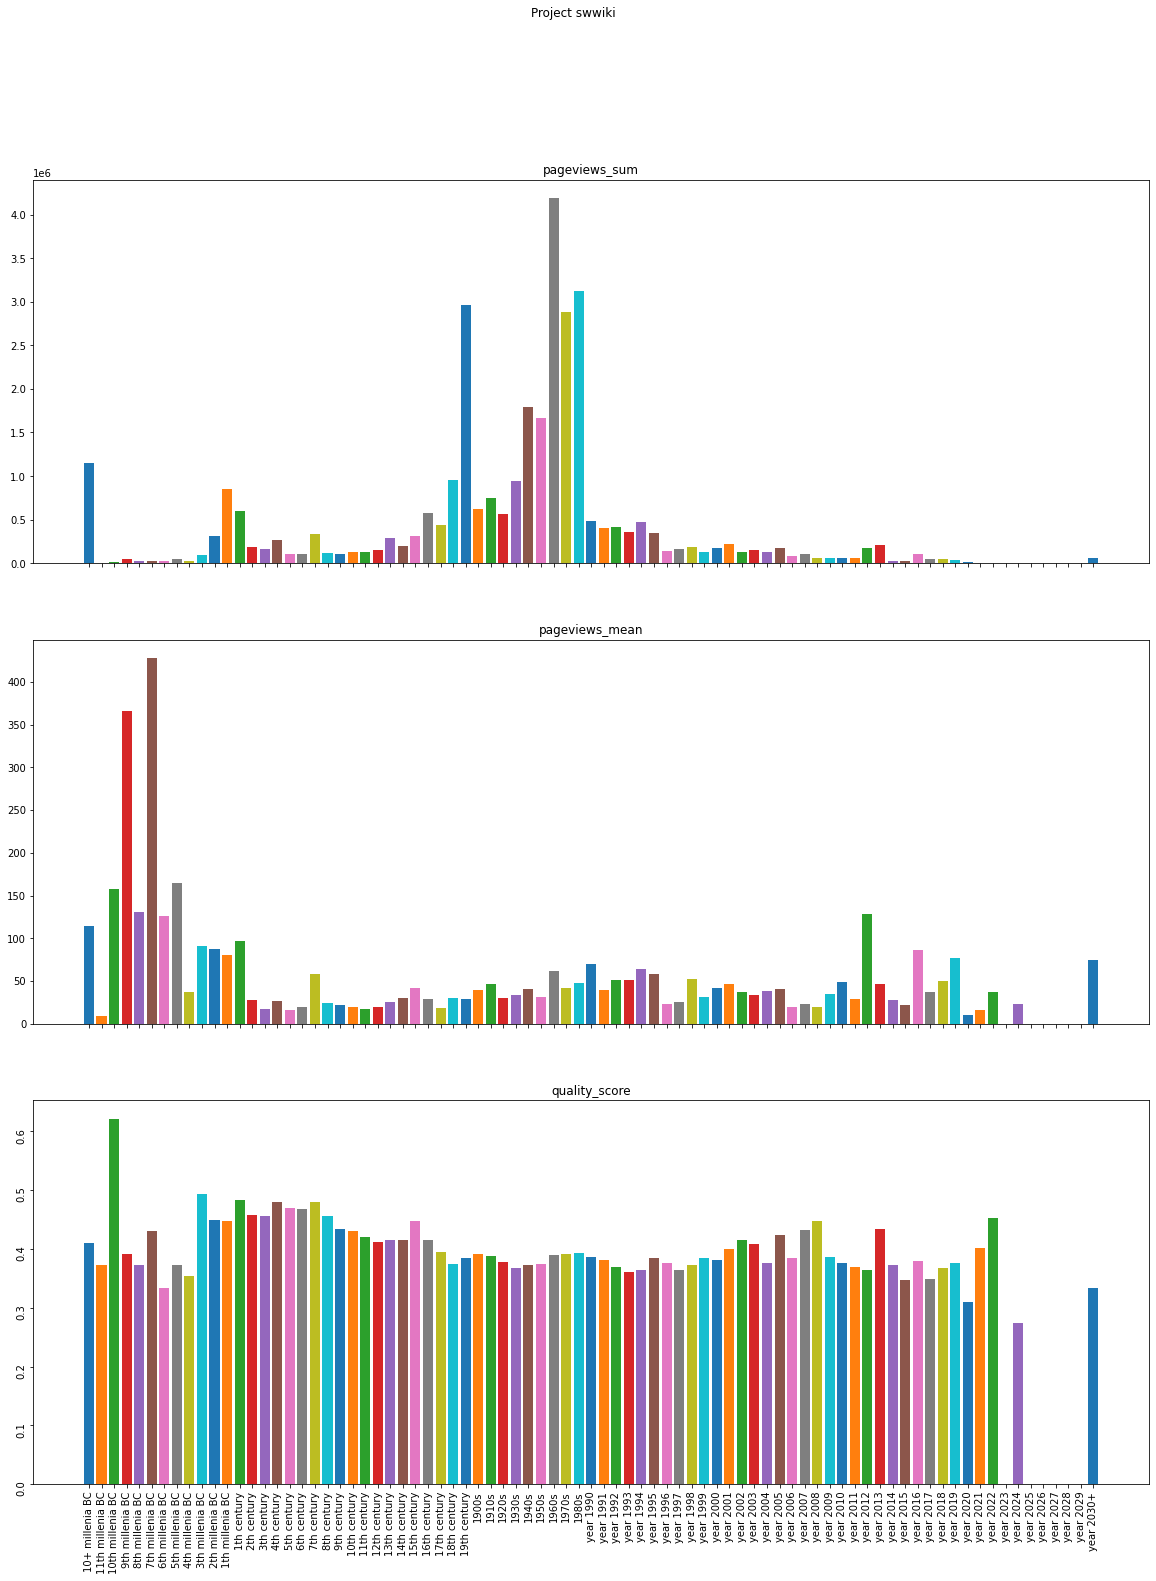

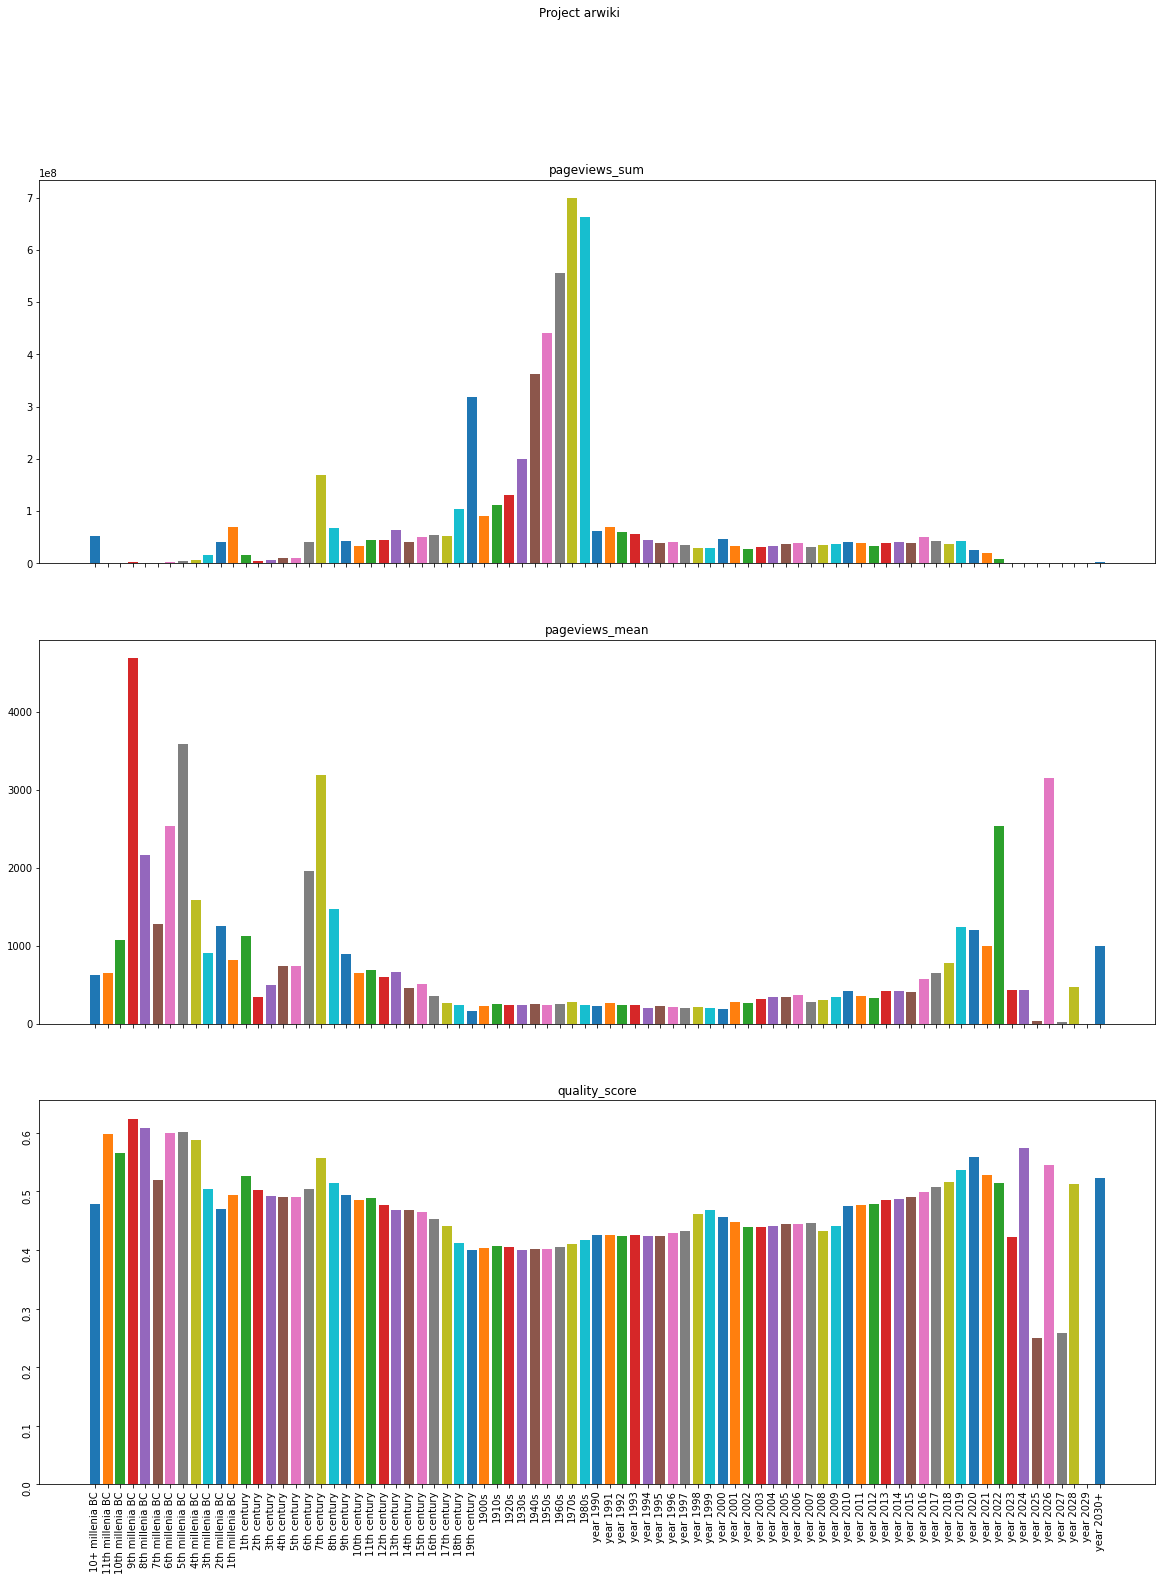

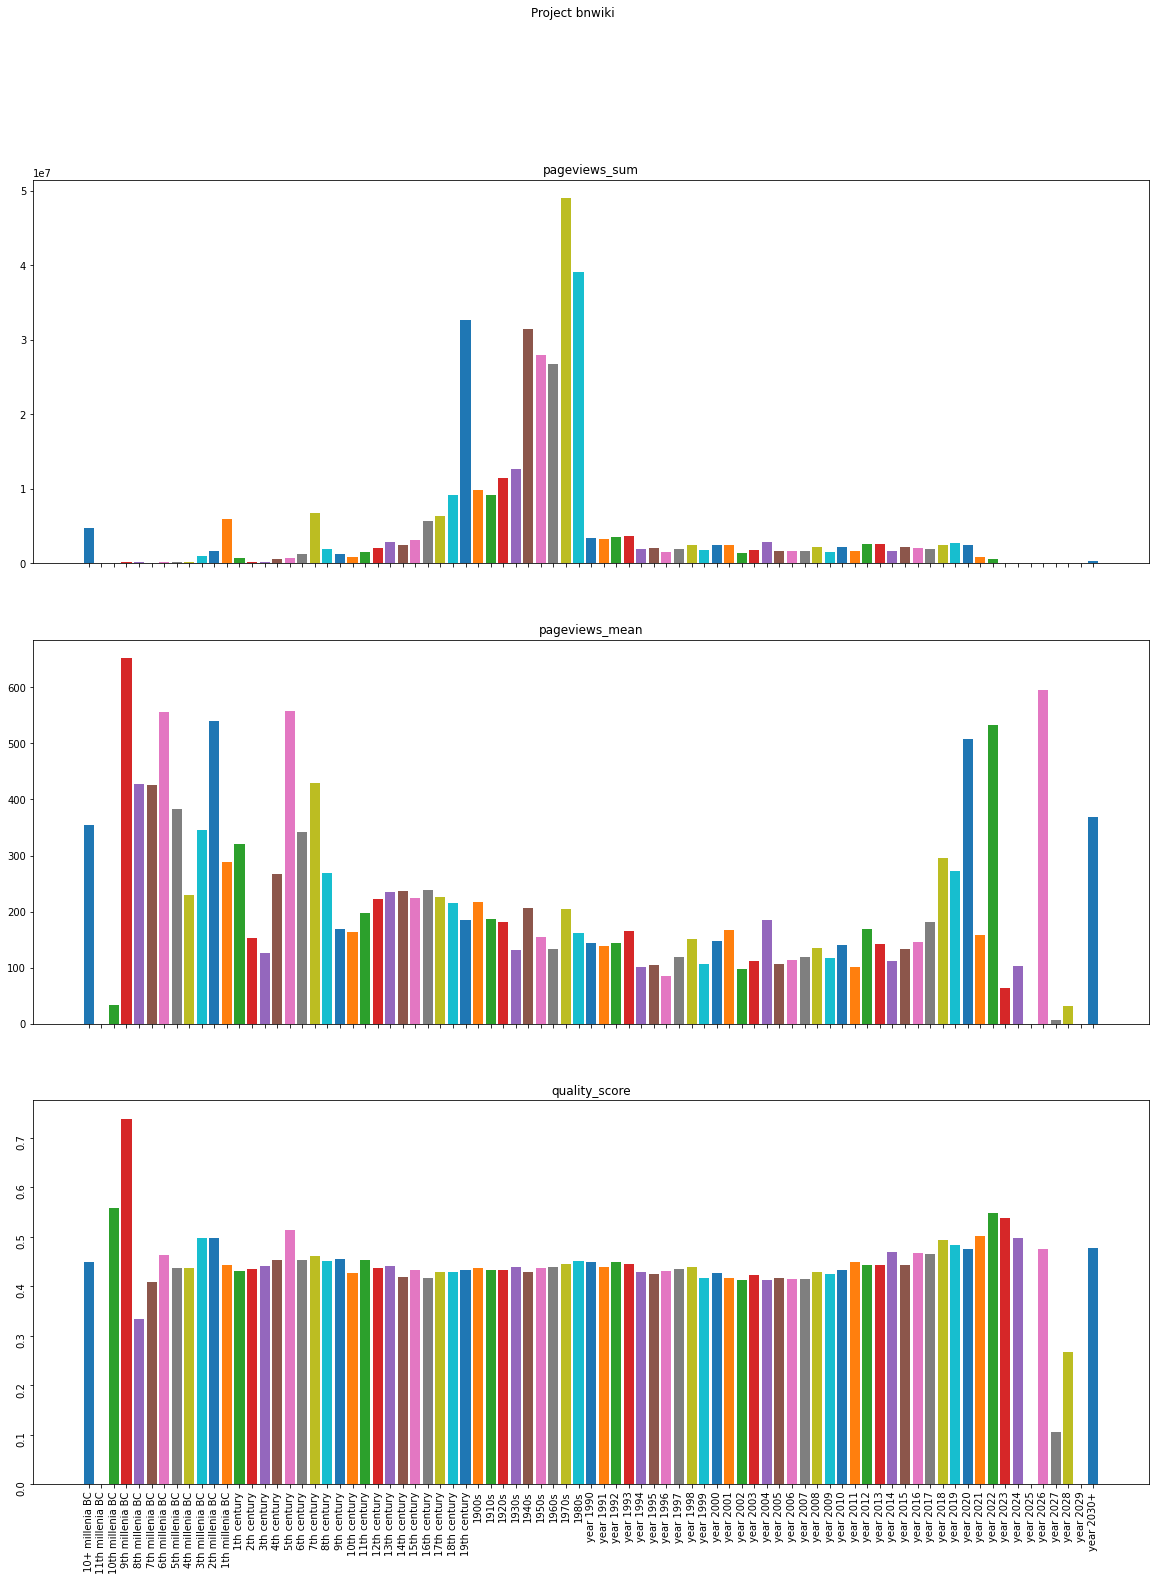

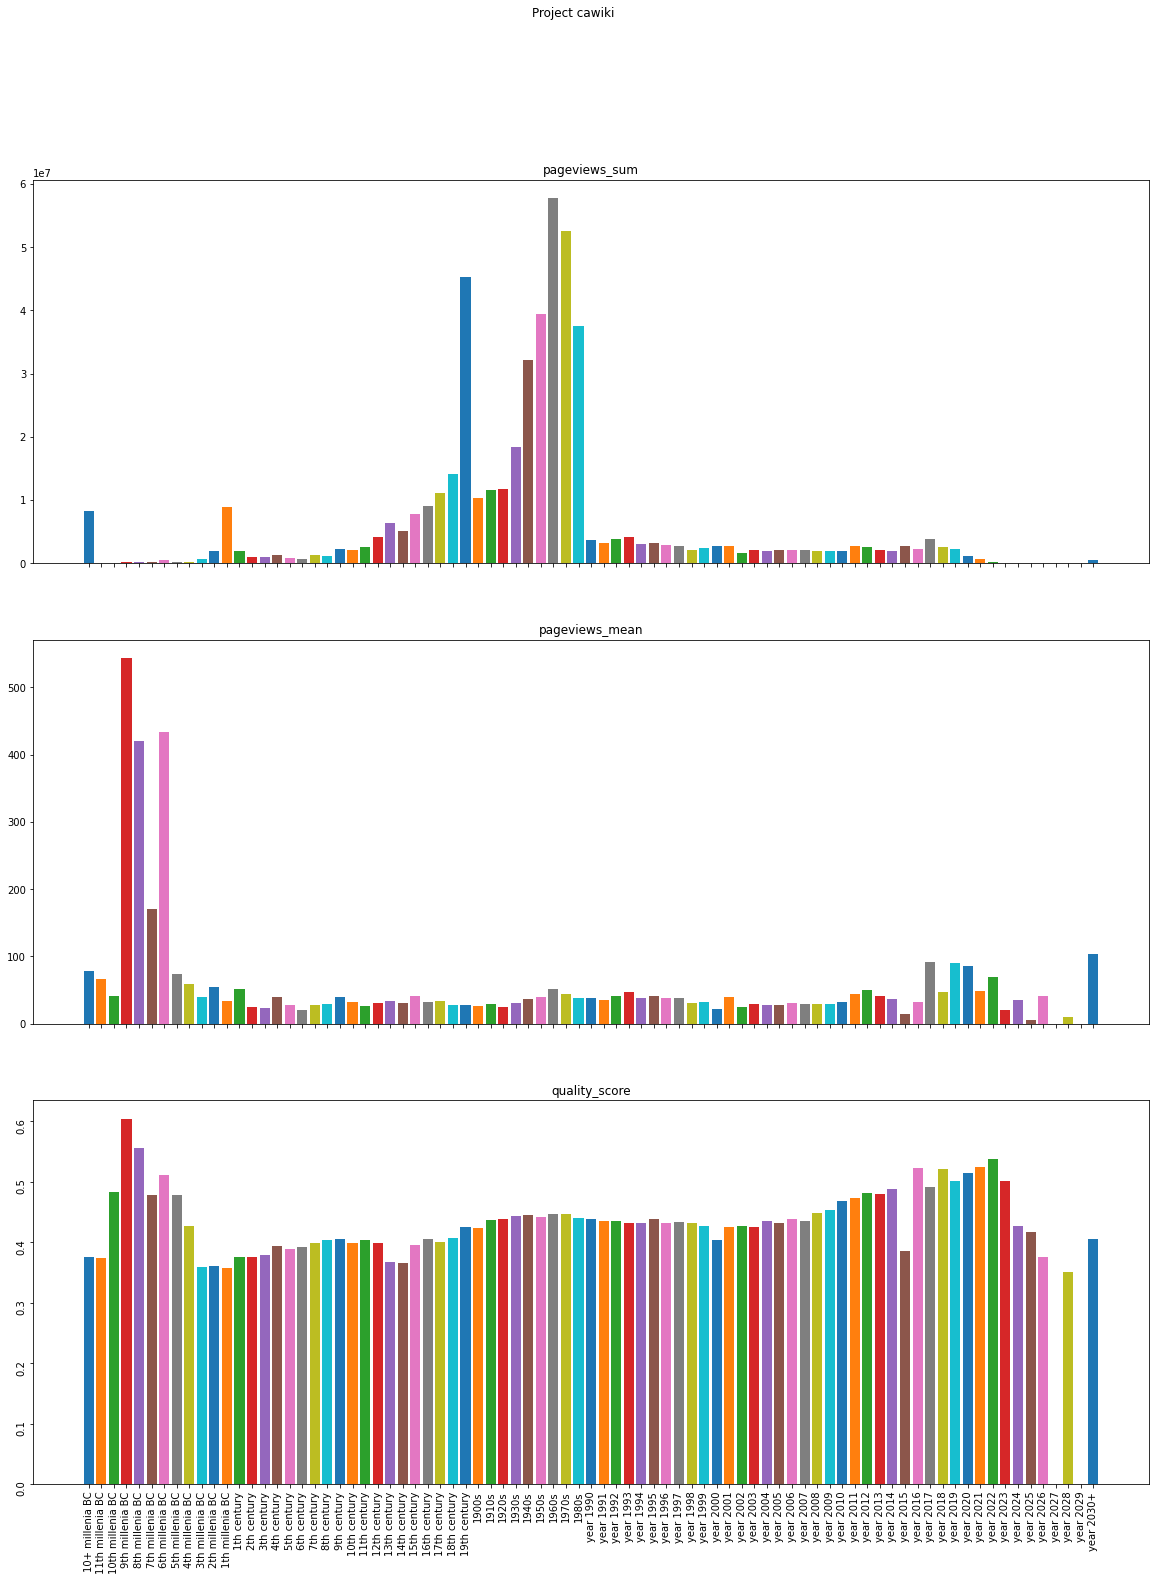

In [62]:
time_gap(metrics_denormalized_df,projects=['enwiki', 'swwiki', 'arwiki', 'bnwiki', 'cawiki'], metrics_to_plot=['pageviews_sum', 'pageviews_mean','quality_score'])



In [21]:
metrics_denormalized_df.columns

['wiki_db', 'time_bucket', 'category', 'by_category', 'totals', 'content_gap']

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='time_bucket'>

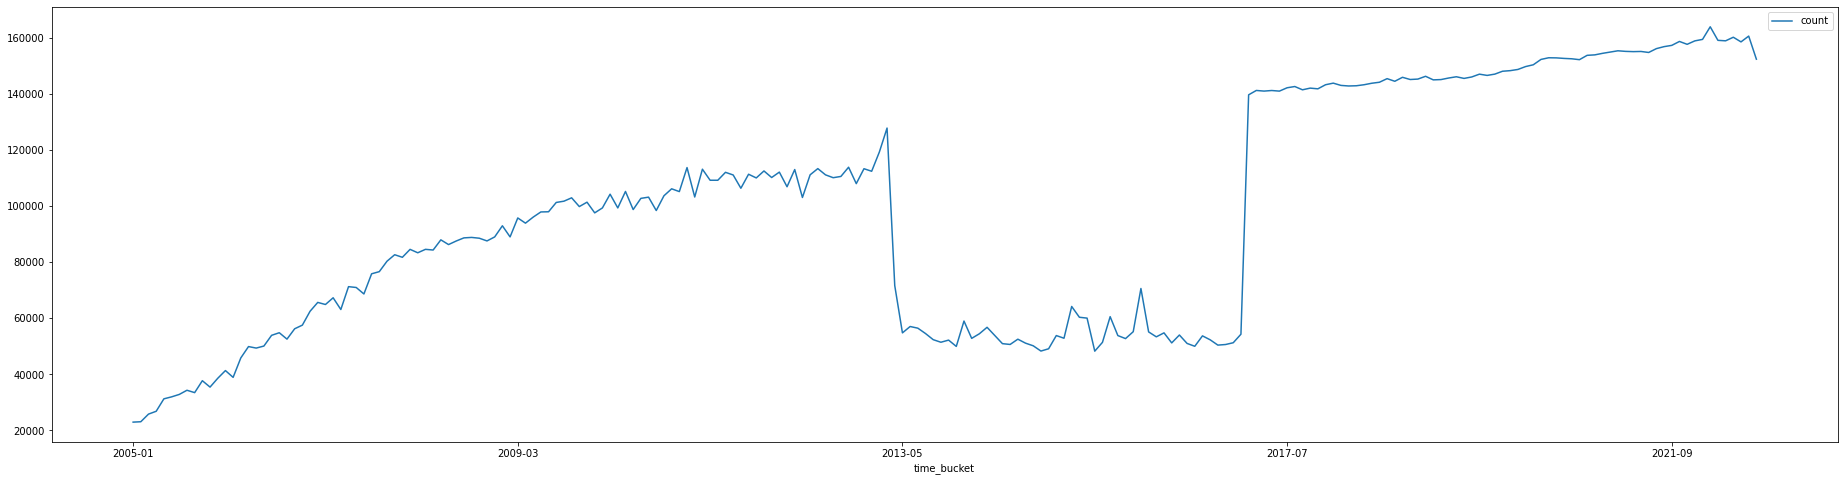

In [22]:
metrics_denormalized_df.groupby('time_bucket').count().orderBy('time_bucket').toPandas().plot('time_bucket','count')

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


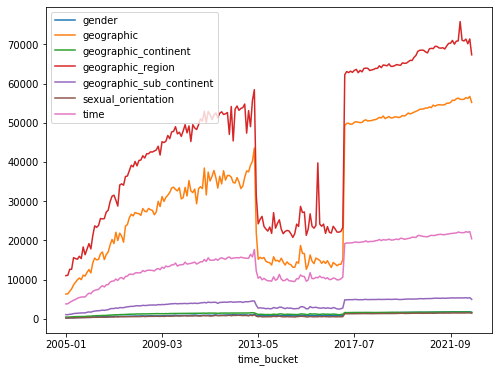

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
for name, group in metrics_denormalized_df.groupby('time_bucket','content_gap').count().orderBy('time_bucket','content_gap').toPandas().groupby('content_gap'):
    group.plot('time_bucket', 'count',ax=ax, label=name)

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


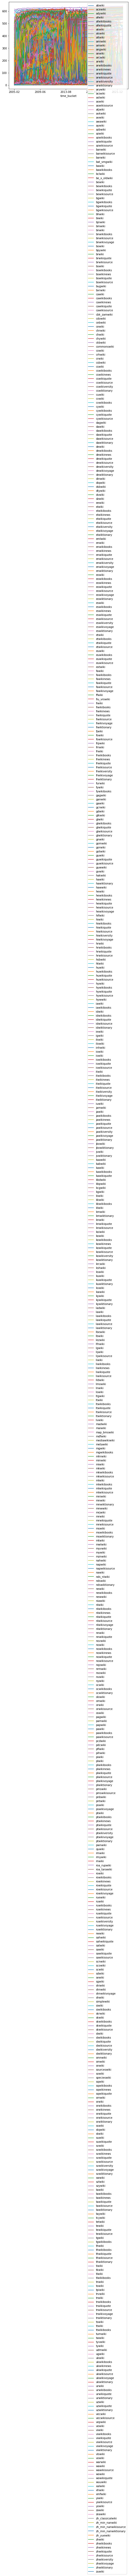

22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_9 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_12 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_16 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_5 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_4 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_2 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_6 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_15 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_19_20 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_21 !
22/08/30 21:49:20 WARN BlockManagerMasterEndpoint: No more replicas 

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
for name, group in metrics_denormalized_df.groupby('time_bucket','wiki_db').count().orderBy('time_bucket','wiki_db').toPandas().groupby('wiki_db'):
    group.plot('time_bucket', 'count',ax=ax, label=name)

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


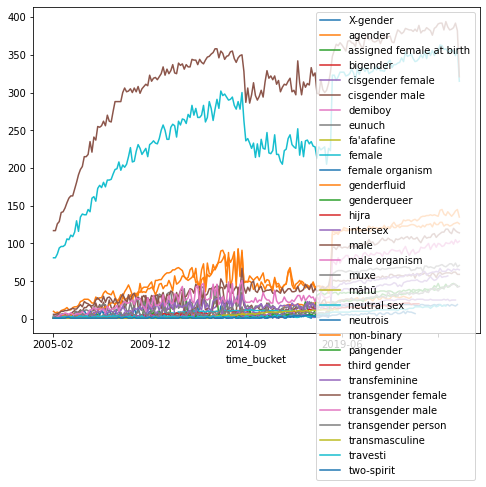

In [13]:

for gap in ["gender"]:#content_gaps:

    s = (metrics_denormalized_df
        .where(F.col('content_gap')==gap)
        .groupby('time_bucket', 'category').count()
        .orderBy('time_bucket', 'category')
    ).toPandas()

    fig, ax = plt.subplots(figsize=(8,6))
    for name, group in s.groupby('category'):
        group.plot('time_bucket', 'count',ax=ax, label=name)
